# Numerical scheme sandbox for GPU-EPS Hav project

## TODO
 * Visualize results
 * Validate/verify/check

## Do initialization and define plot functions

In [199]:
#Lets have matplotlib "inline"
%pylab inline

#Lets have large and high-res figures
%config InlineBackend.figure_format = 'retina'
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [200]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

def plot_vars(xm, ym, B, h):
    # Twice as wide as it is tall.
    fig = plt.figure(figsize=plt.figaspect(0.5))
    
    # First plot
    ax = fig.add_subplot(1, 1, 1, projection='3d')
 
    xxm, yym = np.meshgrid(xm, ym)
   
    surf = ax.plot_surface(xxm, yym, h, rstride=1, cstride=1, cmap=cm.coolwarm,
            linewidth=0, antialiased=False)

    # Second plot
    ax.plot_wireframe(xxm, yym, B, rstride=1, cstride=1)

    plt.show()

def plot_vars_separate(xm, ym, B, h):
    # Twice as wide as it is tall.
    fig = plt.figure(figsize=plt.figaspect(0.5))
    
    # First subplot
    ax = fig.add_subplot(1, 2, 1, projection='3d')
 
    xxm, yym = np.meshgrid(xm, ym)
   
    surf = ax.plot_surface(xxm, yym, h, rstride=1, cstride=1, cmap=cm.coolwarm,
            linewidth=0, antialiased=False)

    # Second subplot
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.plot_wireframe(xxm, yym, B, rstride=1, cstride=1)


    plt.show()

## Define initial conditions for experiments

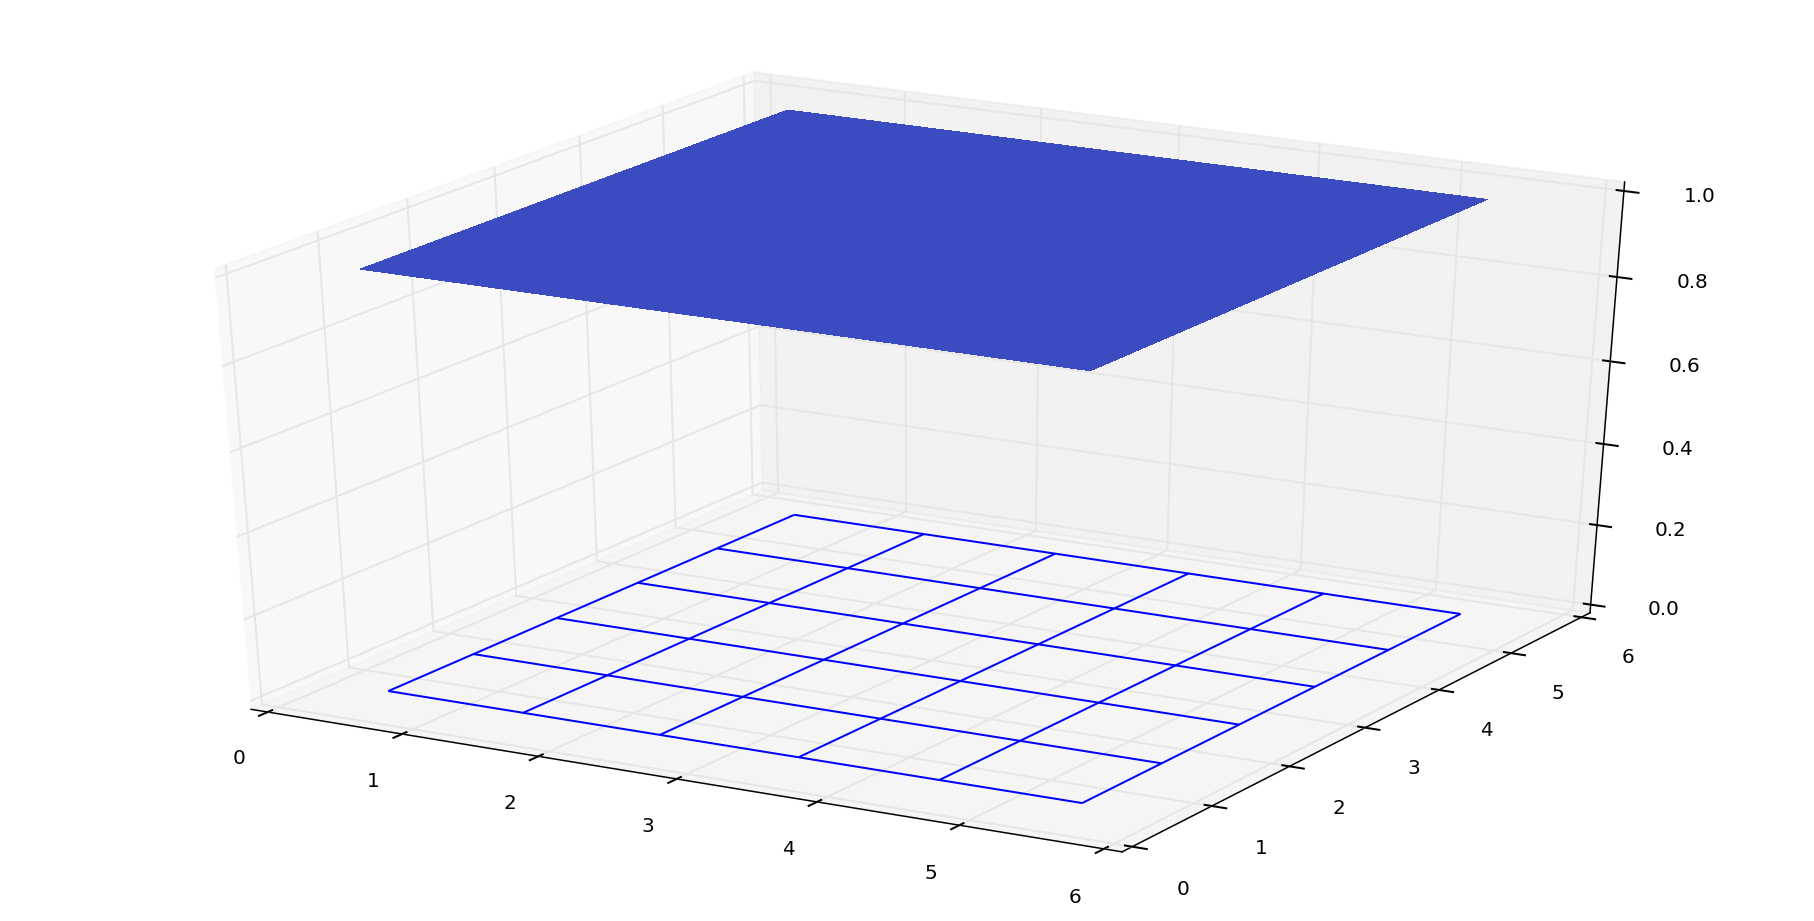

In [201]:
# Define grid (w/o ghost cells)
nx = 5
ny = 5

# Define our physical variables
x = np.linspace(0.0, (nx+2)-1.0, nx+2)
y = np.linspace(0.0, (ny+2)-1.0, ny+2)

# Cell midpoints
xm = np.linspace(0.5, (nx+1)-0.5, nx+1)
ym = np.linspace(0.5, (ny+1)-0.5, ny+1)

dx = 0.1
dy = 0.1
dt = 0.01
g = 9.81

# No friction (yet)
R = 1;

# No coriolis effect (yet)
F = 1;

# Bathymetry
B = np.zeros([nx+1, ny+1]);

#
# Initial conditions
#
w = np.ones([nx+1, ny+1]); # water height

# Make sure that h (water depth) is non-negative initially (w =< B should probably throw an error...)
w = np.maximum(w, B)

h = w - B; # water depth
H = h # equilibrium solution => eta = 0
U = np.zeros([nx+2, ny-1]); # no initial velocity in x-direction
V = np.zeros([nx-1, ny+2]); # no initial velocity in y-direction

eta = np.zeros([nx+1, ny+1]); # deviation from sea surface equilibrium depth, H

# Plot B and h(eta+H) with ghost cells
plot_vars(xm, ym, B, eta+H)

## Run-through of numerical scheme (2D)

We implement a finite-difference based scheme on a Cartesian staggered grid.

Since the variables needs to be evaluated at a different location than they are stored, we do a reconstruction of the variables using (bi)linear interpolation.

In [202]:
# H (hat) reconstructed
Hr_u = np.zeros([nx, ny+1]);
Hr_v = np.zeros([nx+1, ny]);
Hr_u[:,:] = 0.5 * (H[:-1,:] + H[1:,:]); # x-direction
Hr_v[:,:] = 0.5 * (H[:,:-1] + H[:,1:]); # y-direction

First, we compute the depth-averaged velocity in the $x$-direction, U, at cell intersections:

In [203]:
B_u = 1 + R*dt / Hr_u;

P_u = g * Hr_u * (eta[1:,:] - eta[:-1,:]) / dx;

# V (hat) reconstructed (tricky... triple-check!)
Vr = np.zeros([nx, ny+1]);
Vr[1:-1,0] = 0.5 * (V[1:,1] + V[:-1,1]);
Vr[1:-1,1:-2] = 0.25 * (V[1:,1:-3] + V[:-1,1:-3] + V[1:,2:-2] + V[:-1,2:-2]);
Vr[1:-1,-1] = 0.5 * (V[1:,-2] + V[:-1,-2]);

# Boundary conditions in x-direction, Vr (is this correct...? triple-check!)
Vr[0,:] = Vr[1,:];
Vr[-1,:] = Vr[-2,:];

# Do not compute U in the ghost cells => index with 1:-1 in the y-direction
U[1:-1,:] = 1 / B_u[:,1:-1] * (U[1:-1,:] + dt * (F*Vr[:,1:-1] - P_u[:,1:-1]));

Second, we compute the depth-averaged velocity in $y$-direction, V, at cell intersections:

In [204]:
B_v = 1 + R*dt / Hr_v;

P_v = g * Hr_v * (eta[:,1:] - eta[:,:-1]) / dy;

# U (hat) reconstructed (tricky... triple-check!)
Ur = np.zeros([nx+1, ny]);
Ur[0,1:-1] = 0.5 * (U[1,1:] + U[1,:-1]);
Ur[1:-2,1:-1] = 0.25 * (U[1:-3,1:] + U[1:-3,:-1] + U[2:-2,1:] + U[2:-2,:-1]);
Ur[-1,1:-1] = 0.5 * (U[-2,1:] + U[-2,:-1]);

# Boundary conditions in y-direction, Ur (is this correct...? triple-check!)
Ur[:,0] = Ur[:,1];
Ur[:,-1] = Ur[:,-2];

# Do not compute V in the ghost cells => index with 1:-1 in the x-direction
V[:,1:-1] = 1 / B_v[1:-1,:] * (V[:,1:-1] + dt * (F*Ur[1:-1,:] - P_v[1:-1,:]));

Last, we compute the sea surface deviation, $\eta$, at cell centers:

In [214]:
# Update internal domain
eta[1:-1,1:-1] = eta[1:-1,1:-1] - dt/dx * (U[1:-2,:] - U[2:-1,:]) - dt/dy * (V[:,1:-2] - V[:,2:-1]);

After a complete time step, boundary conditions are applied on variables $U$, $V$, and $\eta$:

In [221]:
# Boundary conditions, eta
eta[:,-1] = eta[:,-2]; # north
eta[-1,:] = eta[-2,:]; # east
eta[:,0] = eta[:,1]; # south
eta[0,:] = eta[1,:]; # west

# Boundary conditions, U (north and south can probably be removed...)
#U[:,-1] = U[:,-2]; # north
U[-1,:] = -U[-2,:]; # east
#U[:,0] = U[:,1]; # south
U[0,:] = -U[1,:]; # west

# Boundary conditions, V (east and west can probably be removed...)
V[:,-1] = -V[:,-2]; # north
#V[-1,:] = V[-2,:]; # east
V[:,0] = -V[:,1]; # south
#V[0,:] = V[1,:]; # west